# EAD

In [1]:
import datetime
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import phik
import scipy.stats as stats
import seaborn as sns
import statsmodels.api as sm
import warnings
from tqdm.notebook import tqdm
warnings.filterwarnings("ignore")
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sns.set_theme(context='talk', style='whitegrid', palette='deep')
plt.rcParams['figure.figsize'] = 12, 8
plt.rcParams['font.size'] = 20
plt.rcParams['axes.labelsize'] = 25
plt.rcParams['figure.titlesize'] = 32
plt.rcParams['axes.titlesize'] = 32
plt.rcParams['savefig.format'] = 'pdf'
plt.rcParams['figure.autolayout'] = 'true'
plt.rcParams['figure.frameon'] = 'false'
plt.rcParams['axes.spines.left'] = 'false'
plt.rcParams['axes.spines.right'] = 'false'
plt.rcParams['axes.spines.top'] = 'false'
plt.rcParams['legend.fancybox'] = 'false'
plt.rcParams['axes.spines.bottom'] = 'false'
plt.rcParams['font.size'] = 20
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'
# для графиков, где надо много цветов, юзайте воть:
sns.set_palette(sns.color_palette('deep'))
# а по дефолту воть:
sns.set_palette(sns.color_palette("BuGn_r", n_colors=10)[2::3])
pd.set_option('display.max_columns', 60)

In [20]:
feeding_details_22 = pd.read_csv("datasets/2022-feeding-tasks-details.csv", on_bad_lines="skip")
feeding_22 = pd.read_csv("datasets/2022-feeding-tasks.csv", on_bad_lines="skip")

feeding_details_23 = pd.read_csv("datasets/2022-feeding-tasks-details.csv", on_bad_lines="skip")
feeding_23 = pd.read_csv("datasets/2022-feeding-tasks.csv", on_bad_lines="skip")

feeding_details_24 = pd.read_csv("datasets/2022-feeding-tasks-details.csv", on_bad_lines="skip")
feeding_24 = pd.read_csv("datasets/2022-feeding-tasks.csv", on_bad_lines="skip")

feeding_details_25 = pd.read_csv("datasets/2022-feeding-tasks-details.csv", on_bad_lines="skip")
feeding_25 = pd.read_csv("datasets/2022-feeding-tasks.csv", on_bad_lines="skip")

monthly_feeding = pd.read_excel("datasets/Ekoniva_dataset.xlsx", sheet_name="Feeding")
herd_metrics = pd.read_excel("datasets/Ekoniva_dataset.xlsx", sheet_name="Herd maintenance").replace("-", np.nan)
production_indicators = pd.read_excel("datasets/Ekoniva_dataset.xlsx", sheet_name="Dairy indicators").replace("-", np.nan)

## Описание данных

- feeding-task - все описание кормления по фермам + секциям + группе животного
- detais - хз пока что чем отличаются details от просто feeding-task, мб тут как то поочередно загружаются ингредиенты, потом посмотрим еще
- monthly-feeding - тут название какого-то пресета кормления и распределение по времени на группу животных на конкретной ферме, пока что хз что за пресеты и где их найти
- herd-metrics - стадо, там тоже естьколичество молока(это исследуемая переменная)
- production-indicators - ферма там количество коров разных типов, разделенных по группам и количество молока - или это исследуемая переменная(скорее всего)

> Тут будем действовать от того, как построим исследовательский вопрос, нужно понять как лучше исследовать, по ферме или по стаду, изначально мне кажется 2, поскольку больше переменных по которым можно смотреть переменную интереса
---

## Пример Исследовательских вопросов:
- Как какой-то тип питания (допустим разнообразное питание) влияет на аппетит и следовательно качество дойки коров? $\rightarrow$ Скорее всего придется группировать данные по питанию, жестко изучать, какие корма что означают, чтобы понять что означает разнообразное питание. Если тяжело, можно проанализировать добавки в пищу и их количество, понять как они влияют на аппетит и качество дойки.
- Можно попробовать сделать что то с заболеваниями коров, но насколько я понял, заболевших коров достаточно мало, это может быть безрезультативно. (я не склоняюсь к этому варианту)
- Как изменение количества основных ингредиентов в рационе отражается на аппетите и продуктивности дойных коров в разных физиологических группах? - что то интересное, тут 50/50, может полуиться, может  полностью ничего не найтись
> Итого я склоняюсь к 1 исследовательскому вопросу, он выглядит как наиболее возможный
---

## Распределения

In [21]:
production_indicators

,date,region,prod_farm_name,farm_type,farm_name,cows_total,milk_cows,milk_cows_d0,milk_cows_d1,milk_cows_d2,milk_cows_d3,weekly_milking_per_cow,gross_milk_yield,cow_retired,cow_retired_low_prod,cow_retired_hooves,cow_retired_inj_joint,cow_retired_mastit,cow_retired_jkt,bull_num
0,2022-12-01,Воронеж,ЭНА Восток,ЖК,ЖК Бобров,2878.0,2609.0,69.0,2094.0,340.0,106.0,34.1,86551.0,0.0,NaN,NaN,NaN,NaN,NaN,23.0
1,2022-12-01,Воронеж,ЭНА Восток,ЖК,ЖК Бобров-2,2882.0,2591.0,131.0,2149.0,261.0,50.0,36.3,88816.0,68.0,NaN,NaN,NaN,NaN,NaN,18.0
2,2022-12-01,Воронеж,ЭНА Восток,ЖК,ЖК Верхний Икорец,2893.0,2580.0,101.0,2104.0,375.0,0.0,38.3,98563.0,85.0,NaN,NaN,NaN,NaN,NaN,0.0
3,2022-12-01,Воронеж,ЭНА Восток,ЖК,ЖК Петропавловка,2885.0,2686.0,90.0,2271.0,163.0,162.0,35.2,87647.0,153.0,NaN,NaN,NaN,NaN,NaN,26.0
4,2022-12-01,Воронеж,ЭНА Восток,МТФ,МТФ ЭНАВ,799.0,738.0,8.0,507.0,0.0,223.0,NaN,NaN,66.0,NaN,NaN,NaN,NaN,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1742,2025-07-01,Сибирь,Сибирская Нива Маслянино,ЖК,ЖК Елбань,5882.0,5468.0,169.0,4455.0,288.0,556.0,36.0,191276.0,526.0,0.0,14.0,33.0,13.0,26.0,0.0
1743,2025-07-01,Сибирь,Сибирская Нива Маслянино,ЖК,ЖК Пеньково,4666.0,4172.0,304.0,3023.0,559.0,286.0,36.7,147218.0,189.0,48.0,23.0,24.0,19.0,24.0,12.0
1744,2025-07-01,Сибирь,Сибирская Нива Маслянино,РМ,РМ Пеньково,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,164.0
1745,2025-07-01,Сибирь,Сибирская Нива Черепаново,ЖК,ЖК Огнева Заимка,3544.0,3140.0,214.0,1842.0,1027.0,57.0,40.4,119264.0,115.0,21.0,18.0,20.0,20.0,11.0,10.0


<Axes: xlabel='weekly_milking_per_cow', ylabel='Count'>

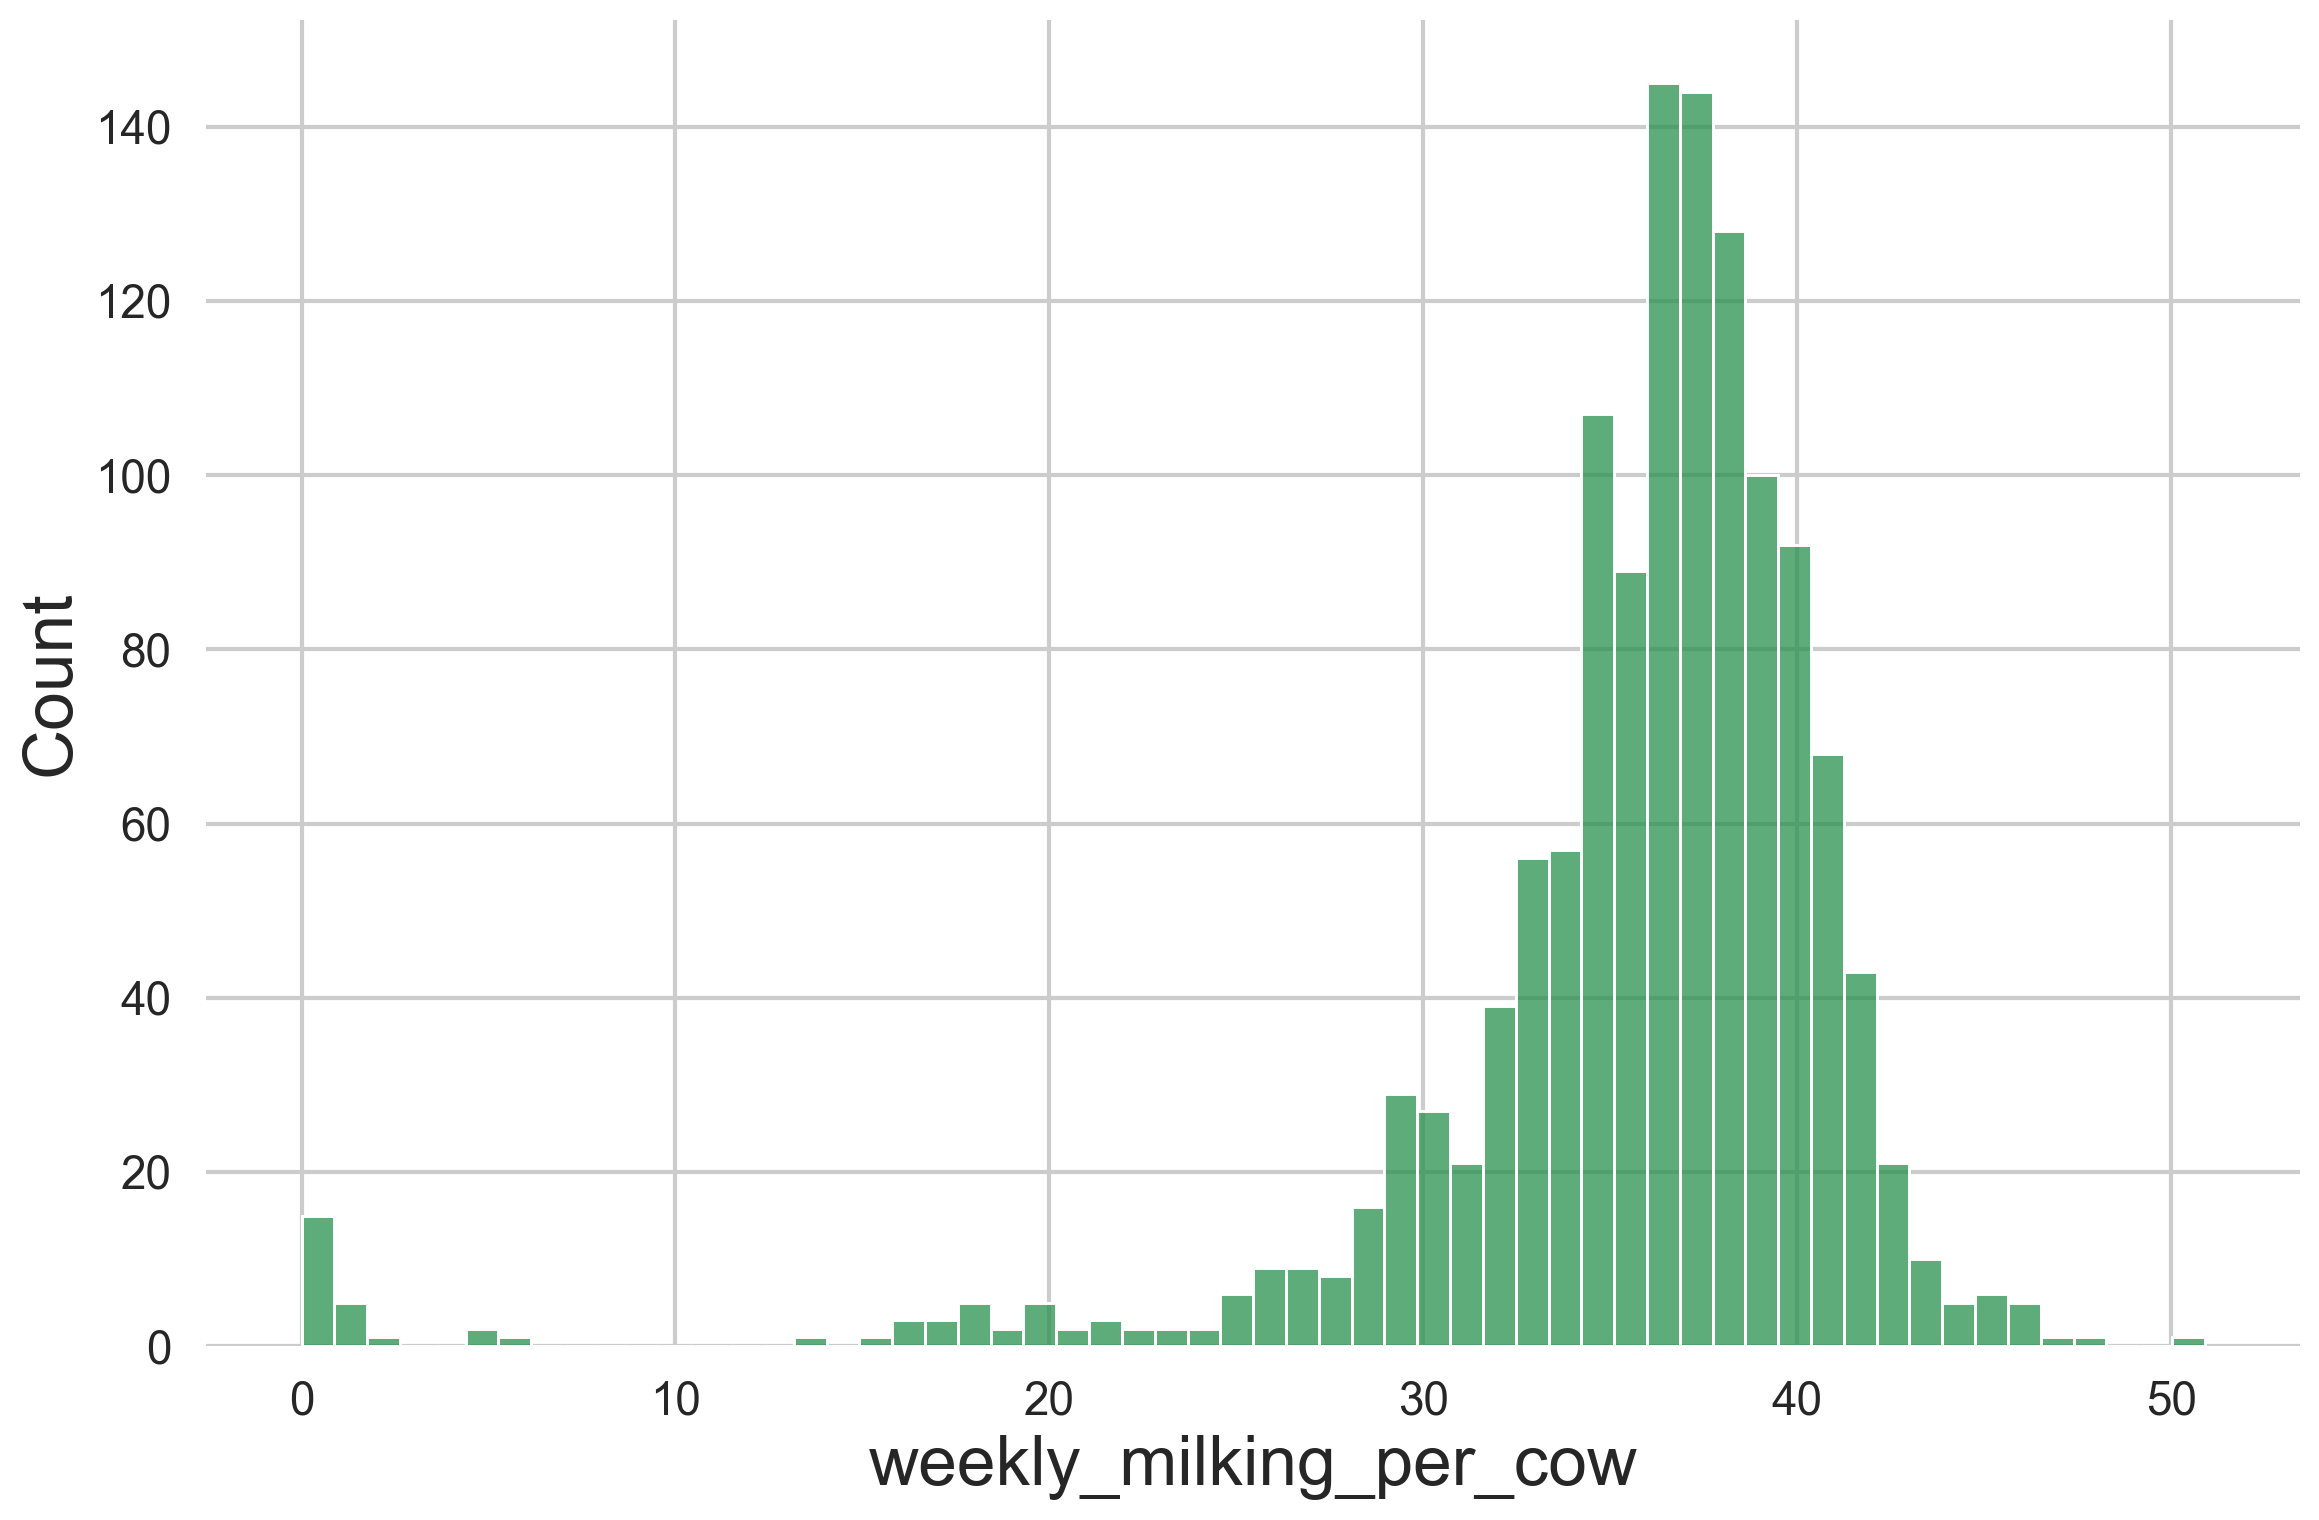

In [22]:
sns.histplot(production_indicators, x="weekly_milking_per_cow")